# Corona in Hamburg

In [1]:
import datetime
import re

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
CORONA_DATA_URL = "https://www.hamburg.de/corona-zahlen/"
MONTHS = ["Januar", "Februar", "März", "April", "Mai", "Juni",
          "Juli", "August", "September", "Oktober", "November", "Dezember"]
BOROUGHS = {
    "Altona": 275264,
    "Bergedorf": 130260,
    "Eimsbüttel": 267051,
    "Hamburg Mitte": 301543,
    "Hamburg Nord": 314593,
    "Harburg": 169426,
    "Wandsbek": 441012,
    "Hamburg": 1899160,
}
FETCH_HISTORIC_DATA = False

In [3]:
def parse_data(r):
    soup = bs4.BeautifulSoup(r.text)
    header = soup.find("h2", text="Neue Fälle: Sieben Tage Chart")
    if header:
        values = [el.text.strip() for el in soup.find_all(attrs={"class": "value_show"})]
        par = soup.find(lambda el: el.name == "p" and el.text.strip().startswith("Beträgt die Anzahl der Neuinfektionen"))
        if values and par:
            date = datetime.datetime.strptime(par.find_all("strong")[1].text[1:-1], "%d.%m.%Y").date()
            dates = reversed([(date - datetime.timedelta(days=d)).isoformat() for d in range(7)])

            with open("corona-hamburg-daily.csv", "r") as f:
                lines = [line.strip() for line in f]

            with open("corona-hamburg-daily.csv", "a") as f:
                for line in [f"{d},{val}" for d, val in zip(dates, values)]:
                    if line not in lines:
                        f.write(f"{line}\n")

    header = soup.find("h3", text="Entwicklung der Zahl der positiv auf COVID-19 getesteten Personen nach Bezirken")
    if header:
        table = header.parent.find("table")
        timestamp = table.parent.parent.find_all("p")[-1].text.replace("Stand:", "")
        timestamp = re.sub(r"[.,]+", " ", timestamp).split()
        timestamp = f"{timestamp[2]}-{MONTHS.index(timestamp[1])+1:0>2}-{int(timestamp[0]):0>2}"
        total_cases = [timestamp,"total"]
        active_cases = [timestamp,"active"]
        for row in table.find_all("tr"):
            borough = row.find(attrs={"data-label": "Bezirk"})
            if not borough:
                continue
            cases = row.find(attrs={"data-label": "Fallzahlen"})
            if cases:
                total_cases.append(cases.text.strip())
            cases = (
                row.find(attrs={"data-label": "Fälle vergangene 14 Tage"})
                or row.find(attrs={"data-label": "Fälle letzte 14 Tage"})
            )
            if cases:
                active_cases.append(cases.text.strip())

        with open("corona-hamburg.csv") as f:
            lines = [line.strip() for line in f]
        
        with open("corona-hamburg.csv", "a") as f:
            total_cases_line = ",".join(total_cases)
            if total_cases_line not in lines and len(total_cases) > 2:
                f.write(f"{total_cases_line}\n")

            active_cases_line = ",".join(active_cases)
            if active_cases_line not in lines and len(active_cases) > 2:
                f.write(f"{active_cases_line}\n")

In [4]:
if FETCH_HISTORIC_DATA:
    r = requests.get(f"http://web.archive.org/cdx/search/cdx?output=json&url={CORONA_DATA_URL}")
    data = r.json()
    header = data[0]
    historic_records = [dict(zip(header, row)) for row in data[1:]]

    for record in historic_records:
        r = requests.get(f"http://web.archive.org/web/{record['timestamp']}/{CORONA_DATA_URL}")
        if r.ok:
            parse_data(r)

In [5]:
r = requests.get(CORONA_DATA_URL)
if r.ok:
    parse_data(r)

In [6]:
with open("corona-hamburg-daily.csv") as f:
    daily_cases = pd.read_csv(f, index_col=0, parse_dates=True)
    daily_cases_rolling7 = daily_cases.rolling(7).sum().dropna()
    daily_cases_rolling14 = daily_cases.rolling(14).sum().dropna()

In [7]:
with open("corona-hamburg.csv") as f:
    df = pd.read_csv(f, index_col=0, parse_dates=True)

In [8]:
total_cases = df[df["type"] == "total"].drop(["type"], axis="columns").astype(int)
active_cases = df[df["type"] == "active"].drop(["type"], axis="columns").astype(int)
new_cases = total_cases.diff().dropna().astype(int)

In [9]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

In [10]:
def stackplot(df, title):
    plt.stackplot(df.index, *df.values.T, labels=df.columns)
    plt.legend(loc="upper left")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cases")
    plt.xticks(rotation=60)
    plt.xlim(xmin=df.index[0])
    plt.grid()

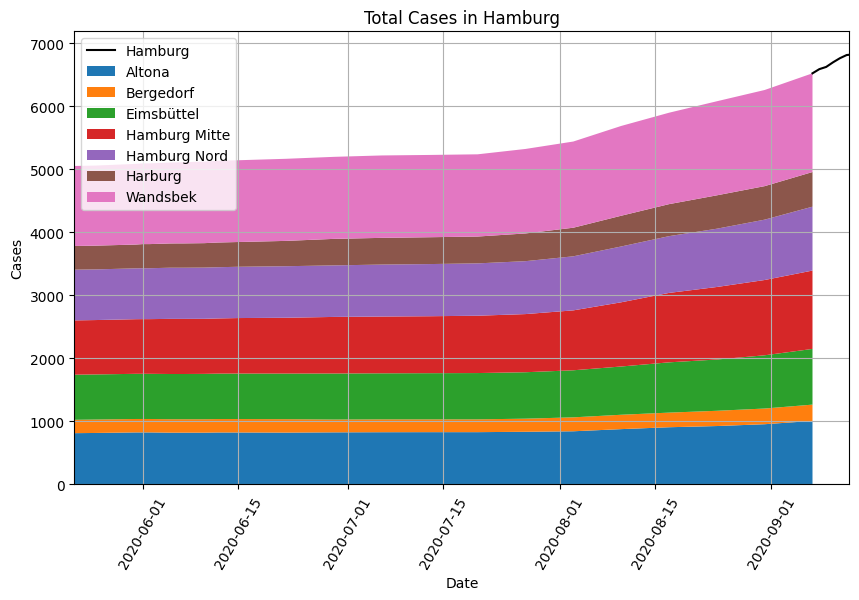

In [11]:
stackplot(total_cases, "Total Cases in Hamburg")
last_total = total_cases.index.intersection(daily_cases.index)[-1]
total_daily_cases = pd.DataFrame([total_cases.T[last_total].sum()], index=[last_total], columns=["cases"]).append(daily_cases[last_total:].drop(index=[last_total])).cumsum()
plt.plot(total_daily_cases.index, total_daily_cases.values, "black", label="Hamburg")
plt.legend(loc="upper left")
plt.show()

In [12]:
total_cases["Hamburg"] = total_cases.sum("columns")
total_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-07-06,829,204,731,901,825,424,1308,5222
2020-07-13,830,203,733,904,828,426,1306,5230
2020-07-20,830,203,735,910,831,426,1305,5240
2020-07-27,836,208,737,923,840,440,1341,5325
2020-08-03,844,221,747,951,858,454,1368,5443
2020-08-10,878,228,766,1019,886,488,1425,5690
2020-08-17,908,232,798,1102,901,508,1451,5900
2020-08-24,927,242,814,1151,925,530,1493,6082
2020-08-31,956,249,845,1195,958,532,1526,6261


In [13]:
total_daily_cases.T

,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14
cases,6526,6592,6627,6700,6765,6816,6827,6848


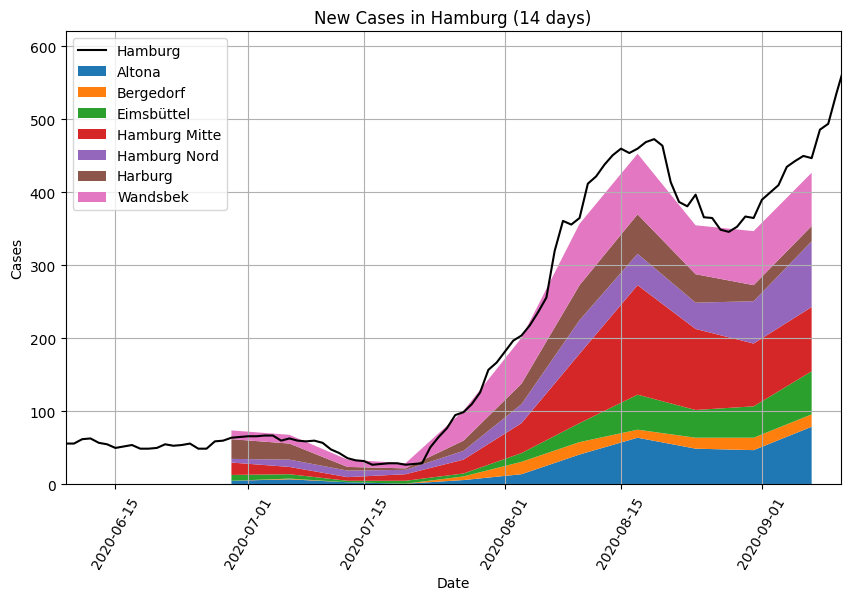

In [14]:
stackplot(active_cases, "New Cases in Hamburg (14 days)")
plt.plot(daily_cases_rolling14.index, daily_cases_rolling14.values, "black", label="Hamburg")
plt.legend(loc="upper left")
plt.xlim(xmin=daily_cases_rolling14.index[0])
plt.show()

In [15]:
active_cases["Hamburg"] = active_cases.sum("columns")
active_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-07-06,7,1,6,10,10,22,12,68
2020-07-13,3,0,2,5,9,5,10,34
2020-07-20,1,0,4,9,6,2,7,29
2020-07-27,6,5,4,19,12,14,41,101
2020-08-03,14,17,12,41,26,28,63,201
2020-08-10,41,17,26,95,46,48,84,357
2020-08-17,64,11,48,150,43,54,83,453
2020-08-24,49,15,38,111,36,39,67,355
2020-08-31,47,17,43,86,58,22,74,347


In [16]:
daily_cases_rolling14.tail(7).T

date,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14
cases,486.0,494.0,536.0,575.0,591.0,579.0,588.0


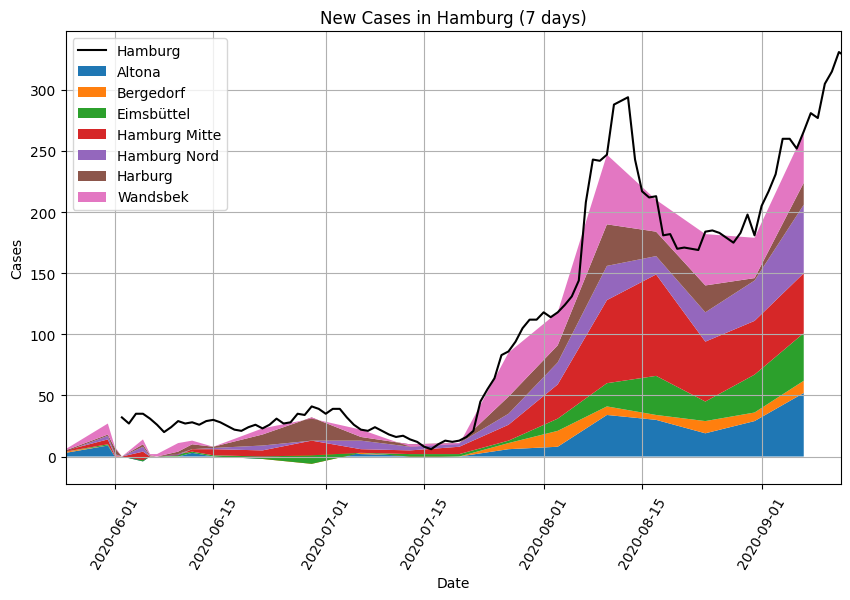

In [17]:
stackplot(new_cases, "New Cases in Hamburg (7 days)")
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values, "black", label="Hamburg")
# plt.plot([new_cases.index[0], daily_cases_rolling7.index[-1]], [900, 900], "r--", label="Restriction Threshold")
plt.legend(loc="upper left")
plt.show()

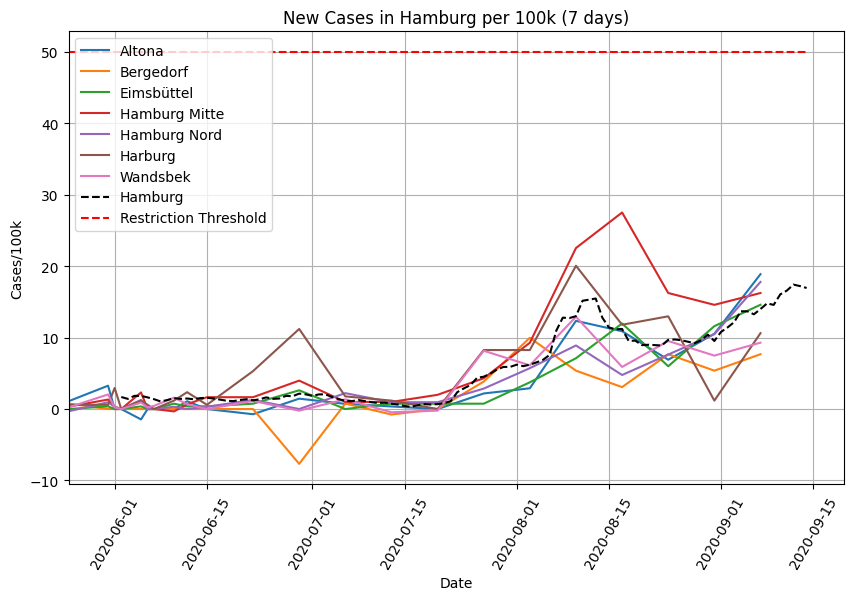

In [18]:
for borough in new_cases.columns:
    plt.plot(new_cases.index, new_cases[borough] / BOROUGHS[borough] * 1e5, label=borough)

plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values / BOROUGHS["Hamburg"] * 1e5, "k--", label="Hamburg")
plt.plot([new_cases.index[0], daily_cases_rolling7.index[-1]], [50, 50], "r--", label="Restriction Threshold")
plt.title("New Cases in Hamburg per 100k (7 days)")
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Cases/100k")
plt.xticks(rotation=60)
plt.xlim(xmin=new_cases.index[0])
plt.grid()
plt.show()

In [19]:
new_cases["Hamburg"] = new_cases.sum("columns")
new_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-07-06,2,1,0,3,7,3,6,22
2020-07-13,1,-1,2,3,3,2,-2,8
2020-07-20,0,0,2,6,3,0,-1,10
2020-07-27,6,5,2,13,9,14,36,85
2020-08-03,8,13,10,28,18,14,27,118
2020-08-10,34,7,19,68,28,34,57,247
2020-08-17,30,4,32,83,15,20,26,210
2020-08-24,19,10,16,49,24,22,42,182
2020-08-31,29,7,31,44,33,2,33,179


In [20]:
daily_cases_rolling7.tail(7).T

date,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14
cases,281.0,277.0,305.0,315.0,331.0,327.0,322.0


In [21]:
(daily_cases_rolling7 / BOROUGHS["Hamburg"] * 1e5).tail(7).round(2).T

date,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14
cases,14.8,14.59,16.06,16.59,17.43,17.22,16.95


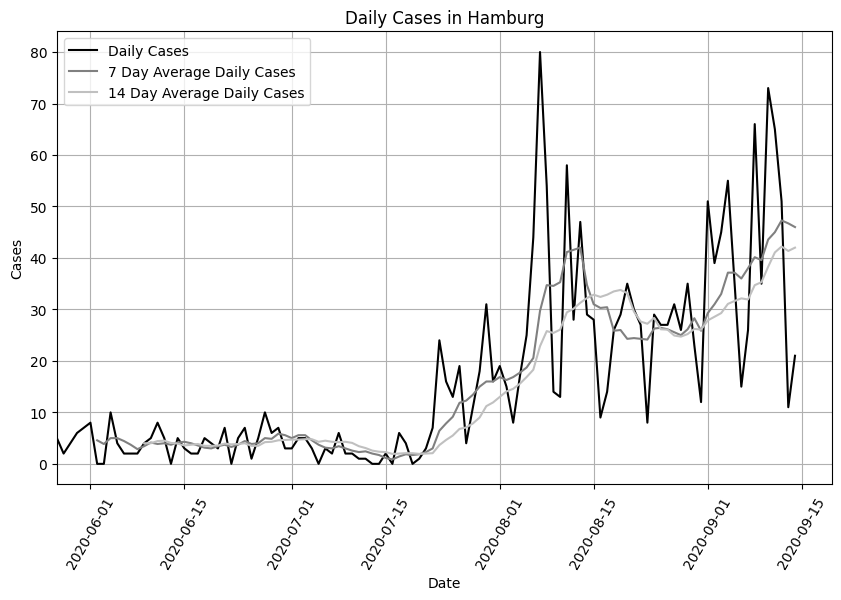

In [22]:
plt.plot(daily_cases.index, daily_cases.values, "black", label="Daily Cases")
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7 / 7, "grey", label="7 Day Average Daily Cases")
plt.plot(daily_cases_rolling14.index, daily_cases_rolling14 / 14, "silver", label="14 Day Average Daily Cases")
plt.title("Daily Cases in Hamburg")
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=60)
plt.xlim(xmin=daily_cases.index[0])
plt.grid()
plt.show()

In [23]:
daily_cases.tail(7).T

date,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14
cases,66,35,73,65,51,11,21
